In [124]:
#STEP 1: Calculate the global (both area-weighted and not weighted) annual mean temperature in Celsius (TA) from 1990 to 2020

import urllib.request
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


# Download the data
url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)

# Open the air temprature dataset and save air temp data
ds = xr.open_dataset(savename)
air = ds["air"]
#print(air) monthly mean surface temp, units are in degrees

# convert degrees to celsius
air = ds.air - 273.15

# Find global unweighted annual average (average over all lat and lon)
average = air.mean(("lon", "lat"))
annual_unweighted = average.groupby("time.year").mean()

# Select data from 1990-2020
annual_mean_unweighted = annual_unweighted.sel(year=slice("1989-12-31", "2020-12-31"))

#Create weights
weights = np.cos(np.deg2rad(air.lat))
weights.name = "weights"
weighted = air.weighted(weights)

#Find mean
weighted_mean = weighted.mean(("lon", "lat"))

# Go from monthly mean to yearly mean
annual_weighted = weighted_mean.groupby('time.year').mean()

# Take subset to get 1990 to 2020
annual_mean_weighted = annual_weighted.where((annual_weighted.year >= 1990) & (annual_weighted.year < 2021), drop=True)

print(annual_mean_weighted)
print(annual_mean_unweighted)


<xarray.DataArray 'air' (year: 31)> Size: 248B
array([13.69749832, 13.59981537, 13.29656219, 13.38782501, 13.55515671,
       13.88332081, 13.46063995, 13.72594547, 14.11997509, 13.86964417,
       13.76299191, 13.99203205, 14.09715939, 14.09807205, 13.9353714 ,
       14.24123287, 14.12703609, 14.2353363 , 13.99539566, 14.04430389,
       14.31394958, 14.0491457 , 14.10944366, 14.17205811, 14.24660397,
       14.56562805, 14.69768143, 14.54633999, 14.32727909, 14.66214085,
       14.75998783])
Coordinates:
  * year     (year) int64 248B 1990 1991 1992 1993 1994 ... 2017 2018 2019 2020
<xarray.DataArray 'air' (year: 31)> Size: 248B
array([ 8.78516865,  8.71488094,  8.32298946,  8.49985695,  8.62871265,
        9.09751701,  8.57421589,  8.85487461,  9.19190884,  8.96420097,
        8.92756557,  9.13376999,  9.23797131,  9.29805088,  8.99719334,
        9.48242855,  9.32206249,  9.4698267 ,  9.20330906,  9.14826965,
        9.51652908,  9.31947041,  9.31527138,  9.30993557,  9.40820026,


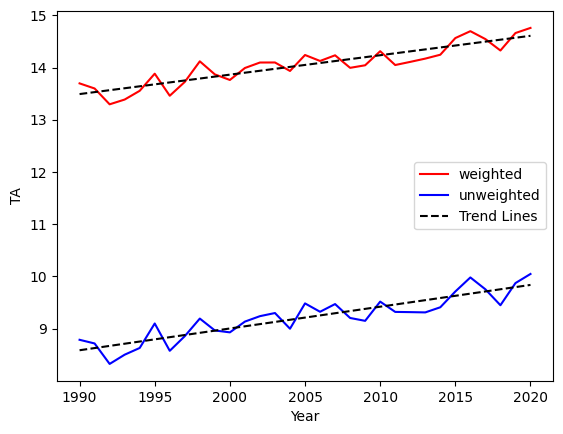

In [125]:
# STEP 2

# Find linear regression lines using polyfit
polyfit_result = annual_mean_weighted.polyfit('year', deg=1) #get coefficients
slope = polyfit_result.polyfit_coefficients.sel(degree=1) # extract slope from coefficients
intercept = polyfit_result.polyfit_coefficients.sel(degree=0) #extract intercept from coefficients
regression_line = slope * annual_mean_weighted['year'] + intercept #create regression line
#repeat process for unweighted data
polyfit_result2 = annual_mean_unweighted.polyfit('year', deg=1) #get coefficients
slope2 = polyfit_result2.polyfit_coefficients.sel(degree=1) # extract slope from coefficients
intercept2 = polyfit_result2.polyfit_coefficients.sel(degree=0) #extract intercept from coefficients
regression_line2 = slope2 * annual_mean_unweighted['year'] + intercept2 #create regression line


# Plot weighted and unweighted annual mean
annual_mean_weighted.plot(label="weighted", color="red") #plot weighted
annual_mean_unweighted.plot(label="unweighted", color="blue") #plot unweighted
regression_line.plot.line(x='year', label='Trend Lines', linestyle="dashed", color="black") #plot linear regression line for weighted
regression_line2.plot.line(x='year',linestyle="dashed", color="black") #plot linear regression line for unweighted
plt.xlabel("Year")
plt.ylabel("TA")
plt.legend()


Text(0.5, 1.0, 'Weighted 31-year Mean Air Temp')

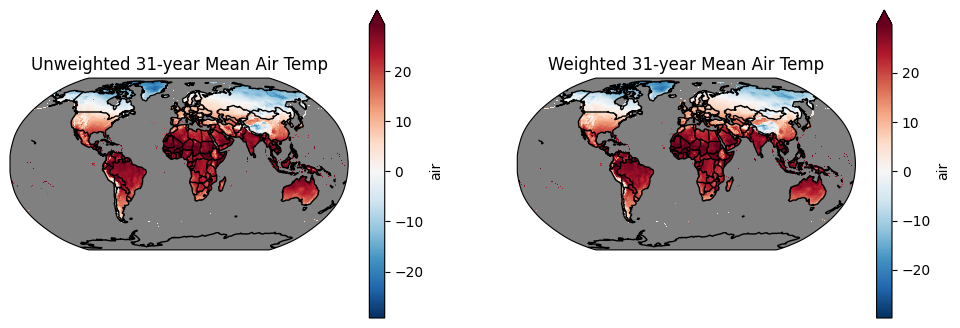

In [146]:
# STEP 3

#!pip install cartopy geoviews hvplot

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# calculate mean over 31 years

air_subset = air.sel(time=slice("1989-12-31", "2020-12-31")) #take original air data and slice
unweighted = air.groupby("time.year").mean() #take unweighted mean of year for all lat and lon
total_mean_unweighted = unweighted.mean("year") #find mean over all years 1990-2020 for all lat and lon

weighted2 = air_subset.weighted(weights) #apply weights to subset of data
total_mean_weighted = weighted2.mean(("time")) #use weights to find mean of all lat and lon over time

# Robinson Projection over all lat and lon for 31-year average

fig, axs = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(), facecolor="gray"), ncols=2, figsize=(12, 4)) #create figure with two subplots with robinson projections

#plot unweighted
p = total_mean_unweighted.isel(lat=range(0,360), lon=range(0,720)).plot(ax=axs[0], transform=ccrs.PlateCarree(), robust=True)
p.axes.coastlines()
p.axes.add_feature(cfeature.BORDERS)

#plot weighted
r = total_mean_weighted.isel(lat=range(0,360), lon=range(0,720)).plot(ax=axs[1], transform=ccrs.PlateCarree(),robust=True)
r.axes.coastlines()
r.axes.add_feature(cfeature.BORDERS)

axs[0].set_title("Unweighted 31-year Mean Air Temp")
axs[1].set_title("Weighted 31-year Mean Air Temp")
